## Import stuff

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
from scipy.linalg import block_diag
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

## Set up the prior
In this case, we need to set up priors over interesting and nuisance parameters. The nuisance parameter prior could be conditional on the interesting parameters.

In [2]:
lower = np.array([0, -1.5])
upper = np.array([0.6, 0])
prior = priors.Uniform(lower, upper)

eta_lower = np.array([-20, 0, 0, -0.5])
eta_upper = np.array([-18, 1, 6, 0.5])
eta_prior = priors.Uniform(eta_lower, eta_upper)

## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

Note: In this case since we are going to infer the nuisance parameter marginalized posterior directly, the simulator takes in interesting parameters only, and draws nuisance parameters from their prior _as part of the simulation process_

In [3]:
JLASimulator = jla.JLA_Model()

def simulator(theta, seed, simulator_args, batch):
    
    eta_prior = simulator_args[0]
    eta = eta_prior.draw()
    
    return JLASimulator.simulation(np.concatenate([theta, eta]), seed)

simulator_args = [eta_prior]
th = np.array([0.2, -0.75])
print(simulator(th,0,simulator_args, 1).shape)

/afs/inf.ed.ac.uk/user/s18/s1832582/Thesis/pydelfi/examples/simulators/jla_supernovae/jla_parser.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype = None, names = True)


(740,)


## Set up the compressor
This must have the signature `compressor(data, args)` -> `np.array([n_summaries])`
In this case we are going to do _nuisance hardened_ Gaussian score compression $$\bar{\mathbf{t}}_\theta = \mathbf{t}_\theta - \mathbf{F}_{\theta\eta}\mathbf{F}^{-1}_{\eta\eta}\mathbf{t}_\eta$$ where $$\mathbf{t}_{(\theta, \eta)} = \nabla_{(\theta, \eta)}^T\boldsymbol\mu_*\mathbf{C}^{-1}(\mathbf{d}-\boldsymbol\mu_*)$$
We'll use the class `score.Gaussian`. For this we'll need some fiducial parameters, the mean its derivative at the fiducial parameters, the inverse covariance, and the inverse Fisher matrix

In [4]:
theta_fiducial = np.array([0.2, -0.75])
eta_fiducial = np.array([-19.04, 0.125, 2.64, -0.05])

mu = JLASimulator.apparent_magnitude(np.concatenate([theta_fiducial, eta_fiducial]))
Cinv = JLASimulator.Cinv

h = np.array(abs(np.concatenate([theta_fiducial, eta_fiducial])))*0.01
dmudt = JLASimulator.dmudt(np.concatenate([theta_fiducial, eta_fiducial]), h)

Compressor = score.Gaussian(len(JLASimulator.data), np.concatenate([theta_fiducial, eta_fiducial]), 
                            mu = mu, Cinv = Cinv, dmudt = dmudt)
Compressor.compute_fisher()
Finv = Compressor.Finv[0:2,0:2]

nuisance_indices = np.arange(2,6)

def compressor(d, compressor_args):
    nuisances_indices = compressor_args[0]
    return Compressor.projected_scoreMLE(d, nuisance_indices)
compressor_args = [nuisance_indices]

## Compress the JLA data

In [5]:
compressed_data = compressor(JLASimulator.data, compressor_args)
print(JLASimulator.data.shape)

(740,)


## Create endemble of NDEs

In [6]:
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=2, n_data=2, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=0),
        ndes.MixtureDensityNetwork(n_parameters=2, n_data=2, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
        ndes.MixtureDensityNetwork(n_parameters=2, n_data=2, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
        ndes.MixtureDensityNetwork(n_parameters=2, n_data=2, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
        ndes.MixtureDensityNetwork(n_parameters=2, n_data=2, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
        ndes.MixtureDensityNetwork(n_parameters=2, n_data=2, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=5)]


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Create DELFI object

In [7]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs, Finv = Finv, theta_fiducial = theta_fiducial, 
                       param_limits = [lower, upper],
                       param_names = ['\Omega_m', 'w_0'], 
                       results_dir = "simulators/jla_supernovae/results_marginal/",
                       input_normalization="fisher")

## Fisher pre-training to initialize the networks

Sampling approximate posterior...
Done.
Removed no burn in


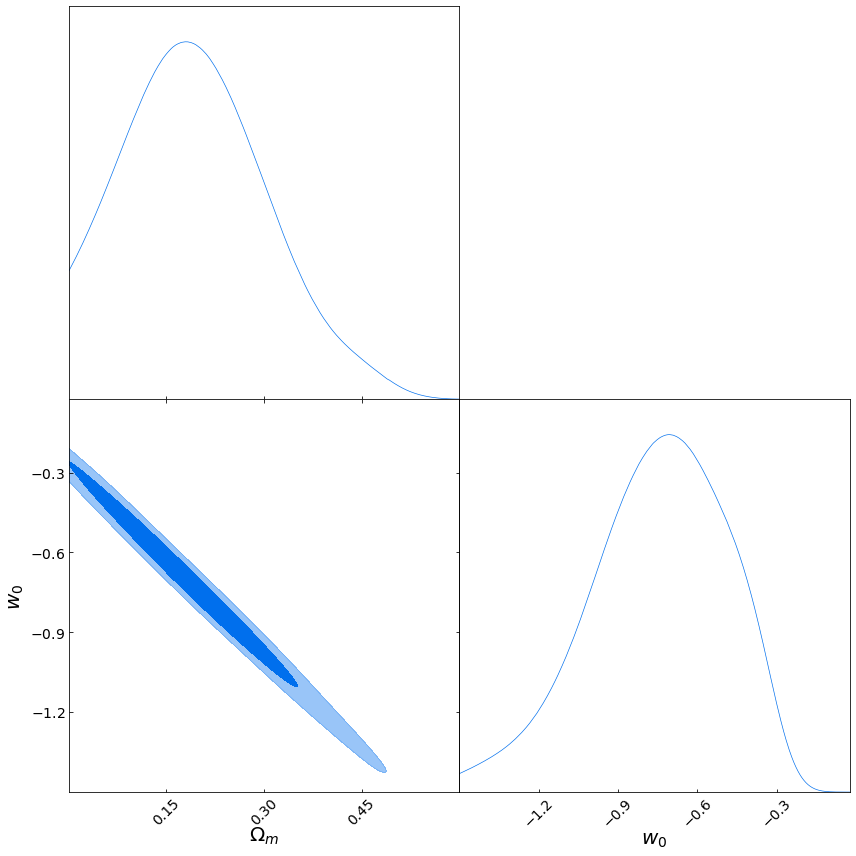

In [8]:
DelfiEnsemble.fisher_pretraining()

## Sequential Neural Likeihood

In [ ]:
n_initial = 100
n_batch = 100
n_populations = 11

DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=10, simulator_args=simulator_args, compressor_args=compressor_args)

## Sample the learned posterior

In [ ]:
posterior_samples = DelfiEnsemble.emcee_sample()

## Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

In [ ]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples])